<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/split-step-fourier-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; #peak intensity               
Ib = 1.0; #background illumination                             
Lambda = 0.651e-6; #wavelength
k0 = 2*np.pi/Lambda; #vacuum wavevector                 
n0 = 1; #background index of refraction      
Lz = 5; #computational length of sample    
Lx = 30e-3; #computational width of sample          
Chirp = -0.0*6*230000.0; #input linear chirp parameter         
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.5e-3 # beam width of gaussian beam parameter

In [0]:
################## Computational Parameters #############
nstepx = 1*1024; #number of transverse grid points
nstepz = 20; #number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; #resolution in the z direction, IMPORTANT
deltaf = 1/Lx; #spatial frequency step       

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = np.arange(0, Lz, deltaz) # z array            
x = -Lx/2 +(np.arange(0, nstepx, 1))*deltax; # x array                    

X, Y = np.meshgrid(x,x); #x and y grid

In [0]:
##########################  Dispersive Step Setup #########################
#this is to get rid of fftshifts and the sort

ntx = 0;             
kx = np.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = np.meshgrid(kx, kx);

ArgumentOfPropagator  = lambda k: ((k*n0)**(-1)*(KX**2+KY**2))*(deltaz/2);             
Propagator = lambda k: np.exp(1j*ArgumentOfPropagator(k))

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# gaussian beam
InputField = np.sqrt(Ip)*np.exp(-((X)**2+(Y)**2)/(w0**2));
InputPower = abs(InputField)**2

MatrixAppoggio = np.zeros(shape=(nstepx, nstepx, nstepz))
MatrixAppoggio[..., 0] = InputField

In [0]:
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation)
        G = 0.0
        B = (1.0 * attenuation)
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440))
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490))
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510))
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580))
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation)
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return np.array([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

In [0]:
cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment

In [0]:
# we define a function to plot 
def plot(Power, figsize=(15, 15), width=15, unit="mm", _cmap=cmap):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, cmap=_cmap, extent=[-width,width,-width,width])

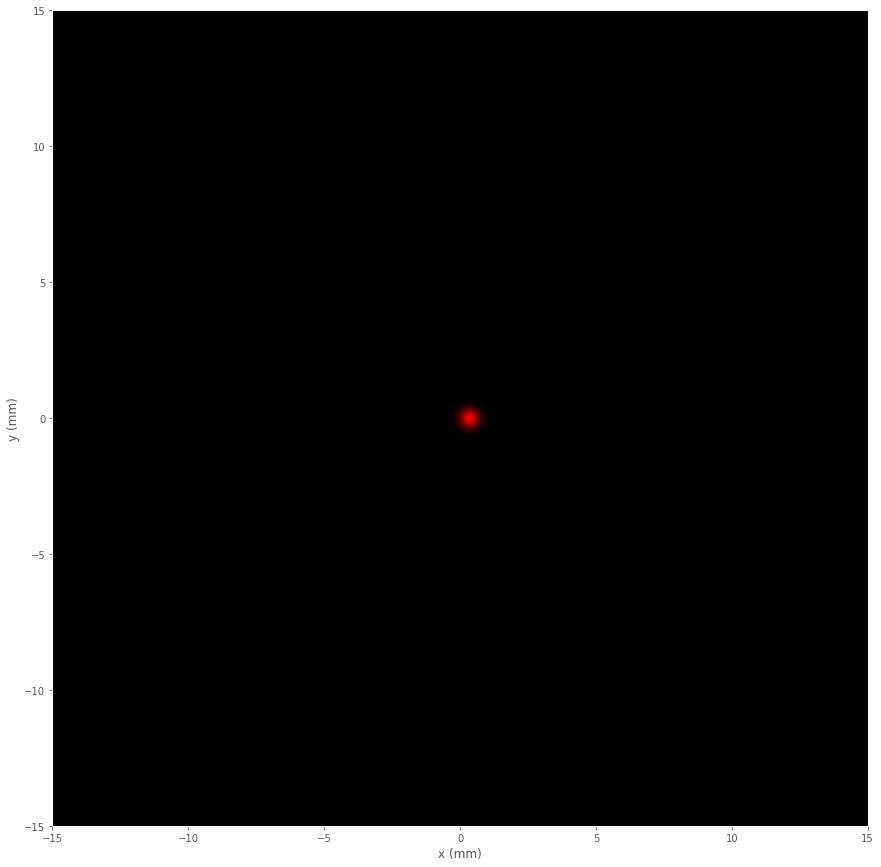

In [44]:
plot(InputPower)

In [0]:
fft2, ifft2= np.fft.fft2, np.fft.ifft2

In [155]:
######                    PROPAGATION LOOP                  ########
def propagate(InputField, k):
  PropagatingField = InputField.copy()
  tstart = time.time()
  _Propagator = Propagator(k)
  for hh in range(nstepz):
      
      PropagatingFieldTransform = fft2(PropagatingField)*_Propagator
      PropagatingField = ifft2(PropagatingFieldTransform)
      MatrixAppoggio[..., hh] = np.abs(PropagatingField)

  print(f"Lasted {time.time()-tstart} seconds")
  return PropagatingField

OutputField = propagate(InputField, k0)
OutputPower = abs(OutputField)**2

OutputTotalPower = np.sum(OutputPower) # total power on output plane
InputTotalPower = np.sum(InputPower) # total power on input plane
gap = (OutputTotalPower-InputTotalPower)/(OutputTotalPower+InputTotalPower)

if abs(gap) > 1e-14:
  print(gap)

Lasted 2.63318133354187 seconds


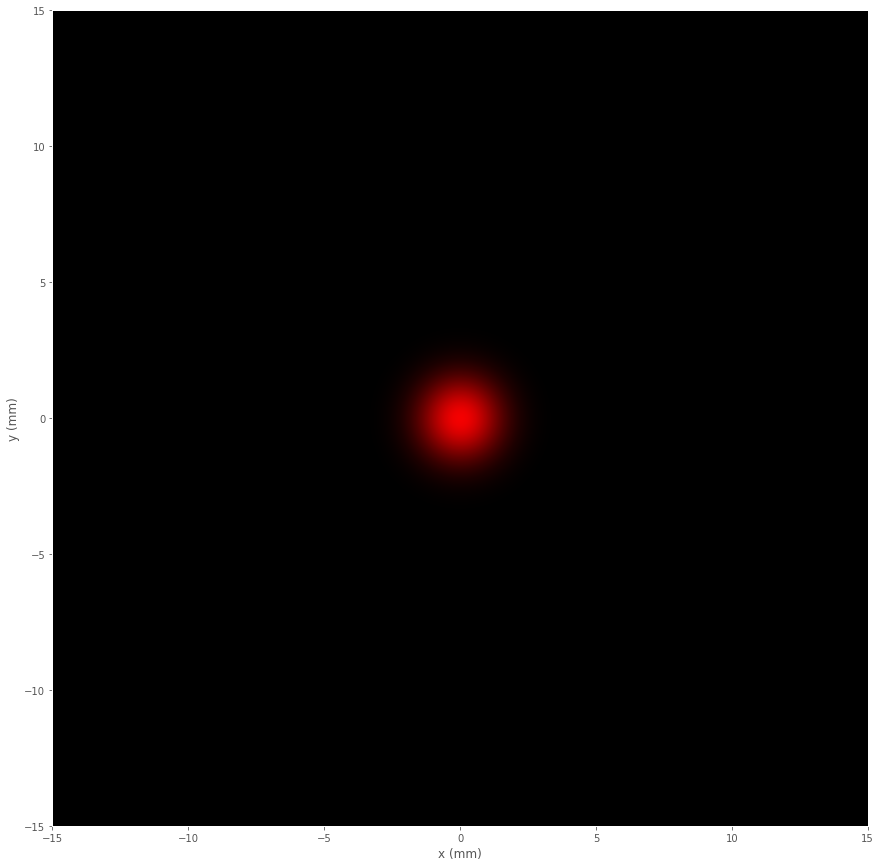

In [141]:
plt.close()
#just for example, a plot with blue light
plot(OutputPower) 

In [142]:
np.sum(MatrixAppoggio[..., -1]-OutputField)
# controllo sia tutto apposto - deve fare tipo 0

-1.8855511949414205e-13j

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


Lasted 2.1956653594970703 seconds
Lasted 2.210221767425537 seconds


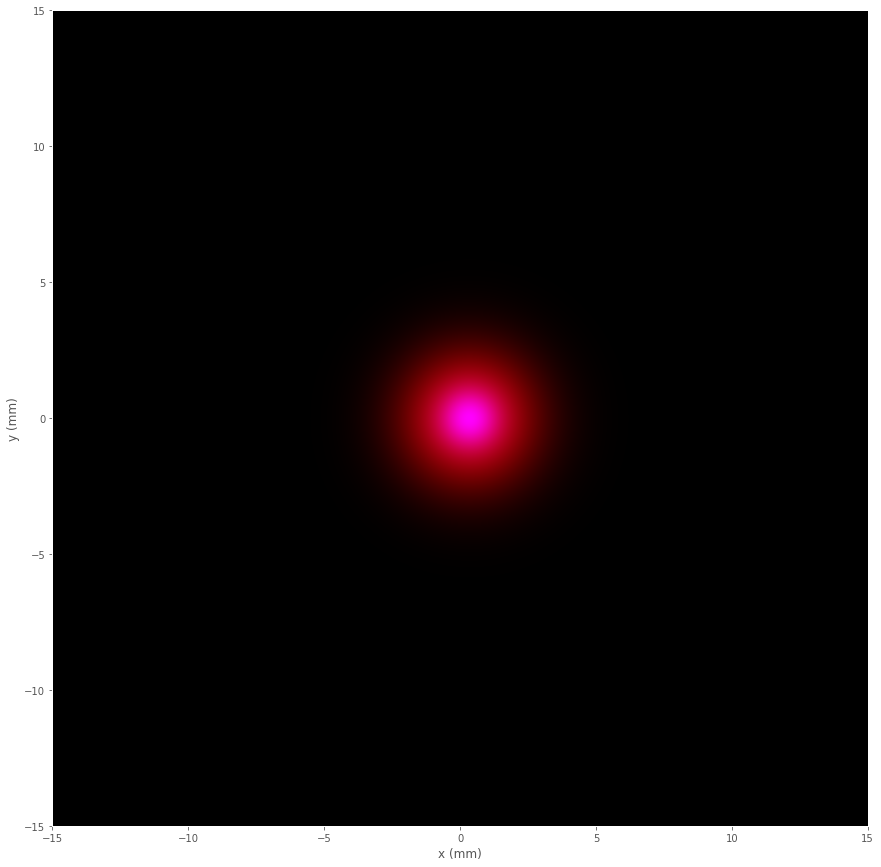

In [34]:
def propagate_and_get_rgb(InputField, wavelength):
  k = 2*np.pi/wavelength
  OutputField = propagate(InputField, k)
  P = abs(OutputField)**2
  rgb = np.stack((P,)*3, axis=-1)/np.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9)

InputField1 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(49*w0**2)); #7x larger
InputField2 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(w0**2));

RedPower = propagate_and_get_rgb(InputField1, 0.645e-6)
BluePower = propagate_and_get_rgb(InputField, 0.44e-6)
plot(RedPower+BluePower) #purple point with red cirle 
# red + blue = purple

In [157]:
print(MatrixAppoggio[511, 511, 18])
np.max(MatrixAppoggio[..., 18])

0.9842820804930459


0.9846917400870359

In [0]:
step = 1 #da modificare
flatx = []
flaty = []
module = []
for i in range(1024):
  for j in range(1024):
    p = MatrixAppoggio[i, j, _z]
    if np.random.rand() < p:
        flatx.append(x[i])
        flaty.append(x[j])
        module.append(p)

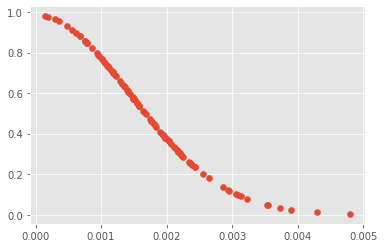

In [207]:
perm = np.random.permutation(len(_x))[:100]
_flatx = np.asarray(flatx)[perm]
_flaty = np.asarray(flaty)[perm]
_module = np.asarray(module)[perm]

plt.scatter(np.sqrt(_x**2+_y**2), _P)

In [0]:
from google.colab import files
import pandas as pd
df = pd.DataFrame({
    "x": _flatx,
    "y": _flaty,
    "field": _module
})
df.to_csv("export.csv")
files.download('export.csv') 